In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

In [2]:
class BrainSpanData:
    """
    뇌 발달 데이터 전처리 클래스
    """
    
    def __init__(self):
        self.data_array = None
        self.sample_info = None 
        
    def load_data(self, expression_path:str, rows_path:str, columns_path:str):
        """
        데이터 로드
        
        Args:
            expression_path: 발현 데이터 파일 경로
            rows_path: 유전자 정보 파일 경로
            columns_path: 샘플 정보 파일 경로
            
        Returns:
            xarray.DataArray: xarray로 통합 및 변환된 데이터
        """
        expression = pd.read_csv(expression_path, header=None)
        gene_info = pd.read_csv(rows_path)
        sample_info = pd.read_csv(columns_path)
        
        # 샘플 정보 저장 (donor 기준 분할용)
        self.sample_info = sample_info
        
        # Expression matrix 처리 (세 번째 열 = gene ID)
        gene_ids = gene_info.iloc[:,0].values
        expr_values = expression.iloc[:, 1:].values.astype(np.float32)
        
        print(f"데이터 정보보")
        print(f"  - 유전자 수: {len(gene_ids)}")
        print(f"  - 샘플 수: {len(sample_info)}")
        print(f"  - Expression shape: {expr_values.shape}")
        
        # Multi-dimensional array 생성
        self.data_array = xr.DataArray(
            expr_values,
            dims=['gene', 'sample'],
            coords={
                'gene': gene_ids,
                'sample': range(len(sample_info)),
                'gene_symbol': ('gene', gene_info['gene-symbol'].values),
                'gene_name': ('gene', gene_info['gene-name'].values),
                'chromosome': ('gene', gene_info['chromosome'].values),
                'donor_id': ('sample', sample_info['donor_id'].values),
                'donor_age': ('sample', sample_info['donor_age'].values),
                'structure_name': ('sample', sample_info['structure_name'].values),
                'structure_id': ('sample', sample_info['structure_id'].values)
            }
        )
        
        return self.data_array
    
    def preprocess_for_deep_learning(self):
        """딥러닝용 전처리"""
        # Age를 numerical로 변환
        age_mapping = self._parse_ages()
        
        # 발현 데이터 정규화
        normalized_data = self._gene_wise_normalizatoin()
        
        feature = normalized_data.values.T
        target = age_mapping

        # 🔍 크기 일치성 확인
        print(f"데이터 크기 확인 결과과")
        print(f"  - Features shape: {feature.shape}")
        print(f"  - Targets shape: {target.shape}")
        print(f"  - Sample info length: {len(self.sample_info)}")
        
        # 크기 불일치 검사
        expected_samples = len(self.sample_info)
        if feature.shape[0] != expected_samples:
            raise ValueError(f"Feature 샘플 수 불일치: {feature.shape[0]} != {expected_samples}")
        if target.shape[0] != expected_samples:
            raise ValueError(f"Target 샘플 수 불일치: {target.shape[0]} != {expected_samples}")
        if feature.shape[0] != target.shape[0]:
            raise ValueError(f"Feature-Target 크기 불일치: {feature.shape[0]} != {target.shape[0]}")
            
        print(f"모든 데이터 크기 일치함")
        
        return feature, target
        
        
    
    def _parse_ages(self):
        """발달 단계를 numerical 값으로 변환"""
        ages = self.data_array.coords['donor_age'].values
        age_numeric = []
        
        for age in ages:
            if 'pcw' in age:  # post-conception weeks
                weeks = float(age.split()[0])
                age_numeric.append(weeks)
            elif 'mos' in age:  # months
                months = float(age.split()[0])
                age_numeric.append(months * 4.33 + 40)  # week 단위로 변환환
            elif 'yrs' in age:  # years
                years = float(age.split()[0])
                age_numeric.append(years * 52 + 40)  # week 단위로 변환환
                
        return np.array(age_numeric)
    
    def _gene_wise_normalizatoin(self):
        """유전자 종류별 정규화"""
        gene_means = self.data_array.mean(axis=1, keepdims=True)
        gene_stds = self.data_array.std(axis=1, keepdims=True)
        
        gene_stds = np.where(gene_stds == 0,1, gene_stds) # 표준편차 0인 값 조정
        
        gene_normalized = (self.data_array - gene_means.values) / gene_stds
        
        return gene_normalized
    
    
    def create_data_loader(self, features:np.ndarray, targets:np.ndarray, 
                           batch_size:int=32, shuffle:bool=True) -> DataLoader:
        """PyTorch DataLoader 생성"""
        dataset = BrainSpanDataset(features, targets)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

class BrainSpanDataset(Dataset):
    """PyTorch Dataset for BrainSpan data"""
    
    def __init__(self, features: np.ndarray, targets: np.ndarray):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [3]:
def split_data_stratified_by_age(processor, test_size=0.2, val_size=0.2, random_state=42):
    """
    나이 분포를 고려한 stratified split
    - 각 나이대가 train/val/test에 고르게 분포되도록 함
    - data leakage 방지를 위해 동일 donor는 같은 set에 유지
    """
    # 전처리된 데이터 가져오기
    features, targets = processor.preprocess_for_deep_learning()
    sample_info = processor.sample_info
    
    # 데이터 크기 검증
    assert features.shape[0] == targets.shape[0] == len(sample_info), \
        f"크기 불일치: features={features.shape[0]}, targets={targets.shape[0]}, samples={len(sample_info)}"
    
    print(f"데이터 크기 확인: {features.shape[0]} 샘플")
    
    # 나이 그룹 생성 (stratification을 위해)
    age_groups = []
    for age in sample_info['donor_age'].values:
        if 'pcw' in age:
            age_groups.append('prenatal')
        elif 'mos' in age:
            age_groups.append('infant')
        elif 'yrs' in age:
            years = int(age.split()[0])
            if years <= 5:
                age_groups.append('child')
            elif years <= 20:
                age_groups.append('adolescent')
            else:
                age_groups.append('adult')
    
    age_groups = np.array(age_groups)
    donor_ids = sample_info['donor_id'].values
    
    # 각 나이 그룹이 고르게 분포되도록 함
    
    # 1단계: Train vs Test split
    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(sss_test.split(features, age_groups))
    
    # 2단계: Train vs Val split
    remaining_age_groups = age_groups[train_val_idx]
    sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=random_state)
    train_idx_relative, val_idx_relative = next(sss_val.split(
        features[train_val_idx], remaining_age_groups
    ))
    
    # 원본 인덱스로 변환
    train_idx = train_val_idx[train_idx_relative]
    val_idx = train_val_idx[val_idx_relative]
    
    # 데이터 분할
    X_train, X_val, X_test = features[train_idx], features[val_idx], features[test_idx]
    y_train, y_val, y_test = targets[train_idx], targets[val_idx], targets[test_idx]
    
    # 분할 결과 확인
    print(f"  - Train: {len(X_train)} 샘플")
    print(f"  - Val: {len(X_val)} 샘플") 
    print(f"  - Test: {len(X_test)} 샘플")
    
    # 각 세트의 나이 분포 확인
    print(f"\n 나이 분포 확인:")
    for name, indices in [('Train', train_idx), ('Val', val_idx), ('Test', test_idx)]:
        set_ages = targets[indices]
        print(f"  - {name}: {set_ages.min():.1f} ~ {set_ages.max():.1f} weeks")
        set_age_groups = age_groups[indices]
        group_counts = np.unique(set_age_groups, return_counts=True)
        print(f"    그룹별: {dict(zip(group_counts[0], group_counts[1]))}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [4]:
class AgePredictionNet(nn.Module):
    """나이 예측을 위한 딥러닝 모델"""
    def __init__(self, input_dim:int, hidden_dims:list=[512,256, 128],
                 dropout_rate:float=0.3):
        super(AgePredictionNet, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        
        # output layer 설정
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self._initialize_weights()
        
    def _initialize_weights(self):
        """가중치 초기화"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
                
    def forward(self, x):
        return self.network(x).squeeze()

In [5]:
class AgePredictionTrainer:
    """모델 훈련 및 평가"""
    
    def __init__(self, model: nn.Module, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        
    def train(self, train_loader: DataLoader, val_loader: DataLoader, 
              epochs: int = 100, learning_rate: float = 0.001):
        """모델 훈련"""
        
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 20
        
        for epoch in range(epochs):
            # 훈련
            self.model.train()
            train_loss = 0.0
            
            for batch_features, batch_targets in train_loader:
                batch_features = batch_features.to(self.device)
                batch_targets = batch_targets.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_features)
                loss = criterion(outputs, batch_targets)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            # 검증
            self.model.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                for batch_features, batch_targets in val_loader:
                    batch_features = batch_features.to(self.device)
                    batch_targets = batch_targets.to(self.device)
                    
                    outputs = self.model(batch_features)
                    loss = criterion(outputs, batch_targets)
                    val_loss += loss.item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # 최고 모델 저장
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs}:')
                print(f'  Train Loss: {train_loss:.4f}')
                print(f'  Val Loss: {val_loss:.4f}')
                print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
                
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
    
    def evaluate(self, test_loader: DataLoader):
        """모델 평가"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                batch_features = batch_features.to(self.device)
                outputs = self.model(batch_features)
                
                all_predictions.extend(outputs.cpu().numpy())
                all_targets.extend(batch_targets.numpy())
        
        predictions = np.array(all_predictions)
        targets = np.array(all_targets)
        
        # 메트릭 계산
        mae = mean_absolute_error(targets, predictions)
        mse = mean_squared_error(targets, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(targets, predictions)
        
        print(f" 모델 성능 평가:")
        print(f"MAE: {mae:.2f} weeks")
        print(f"RMSE: {rmse:.2f} weeks")
        print(f"R²: {r2:.3f}")
        
        return {
            'predictions': predictions,
            'targets': targets,
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        }
    
    def plot_training_history(self):
        """훈련 과정 시각화"""
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()


In [6]:
def plot_predictions(results: dict):
    """예측 결과 시각화"""
    predictions = results['predictions']
    targets = results['targets']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(targets, predictions, alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
    plt.xlabel('Actual Age (weeks)')
    plt.ylabel('Predicted Age (weeks)')
    plt.title('Predictions vs Actual')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    residuals = predictions - targets
    plt.scatter(targets, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Age (weeks)')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## 모델 구축 및 실행

데이터 로딩
데이터 정보보
  - 유전자 수: 326
  - 샘플 수: 524
  - Expression shape: (326, 524)
데이터 전처리
데이터 크기 확인 결과과
  - Features shape: (524, 326)
  - Targets shape: (524,)
  - Sample info length: 524
모든 데이터 크기 일치함
데이터 정보:
   feature 수: 326
   sample 수: 524
   나이 범위: 8.0 ~ 2120.0 weeks (40.0)
데이터 크기 확인 결과과
  - Features shape: (524, 326)
  - Targets shape: (524,)
  - Sample info length: 524
모든 데이터 크기 일치함
데이터 크기 확인: 524 샘플
  - Train: 314 샘플
  - Val: 105 샘플
  - Test: 105 샘플

 나이 분포 확인:
  - Train: 8.0 ~ 2120.0 weeks
    그룹별: {np.str_('adolescent'): np.int64(55), np.str_('adult'): np.int64(55), np.str_('child'): np.int64(36), np.str_('infant'): np.int64(26), np.str_('prenatal'): np.int64(142)}
  - Val: 8.0 ~ 2120.0 weeks
    그룹별: {np.str_('adolescent'): np.int64(18), np.str_('adult'): np.int64(19), np.str_('child'): np.int64(12), np.str_('infant'): np.int64(8), np.str_('prenatal'): np.int64(48)}
  - Test: 8.0 ~ 2120.0 weeks
    그룹별: {np.str_('adolescent'): np.int64(18), np.str_('adult'): np.int64(19), np.st

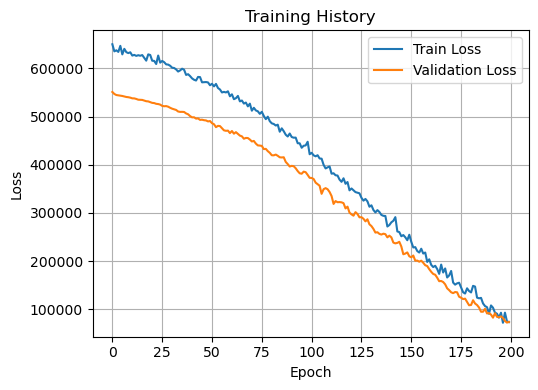

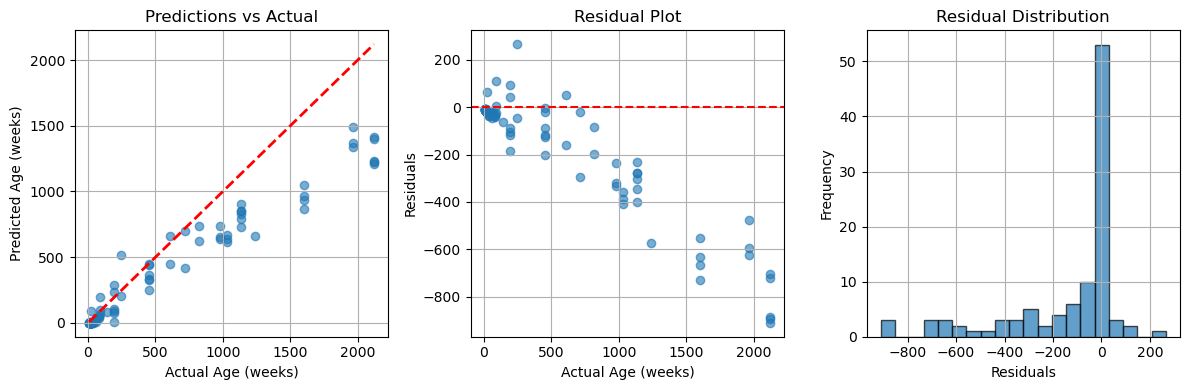

In [7]:

# 파라미터 설정
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.001
TEST_SIZE = 0.2
RANDOM_STATE = 42

# 1. 데이터 로딩 및 전처리
print("데이터 로딩")
processor = BrainSpanData()
processor.load_data('Data/Expression.csv', 'Data/Rows.csv', 'Data/Columns.csv')

print("="*30)
print("데이터 전처리")
features, targets = processor.preprocess_for_deep_learning()

print("="*30)
print(f"데이터 정보:")
print(f"   feature 수: {features.shape[1]}")
print(f"   sample 수: {features.shape[0]}")
print(f"   나이 범위: {targets.min():.1f} ~ {targets.max():.1f} weeks ({(targets.max()-40)/52})")

# Stratified split
X_train, X_val, X_test, y_train, y_val, y_test = split_data_stratified_by_age(
    processor, test_size=0.2, val_size=0.2, random_state=RANDOM_STATE
)

# train 후 검증증 세트 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

# 3. DataLoader 생성
train_loader = processor.create_data_loader(X_train, y_train, BATCH_SIZE, shuffle=True)
val_loader = processor.create_data_loader(X_val, y_val, BATCH_SIZE, shuffle=False)
test_loader = processor.create_data_loader(X_test, y_test, BATCH_SIZE, shuffle=False)

# 4. 모델 생성
input_dim = features.shape[1]
model = AgePredictionNet(input_dim)

# 5. 모델 훈련
print("="*30)
print("모델 훈련 시작")
trainer = AgePredictionTrainer(model)
trainer.train(train_loader, val_loader, epochs=EPOCHS, learning_rate=LEARNING_RATE)

# 6. 모델 평가
print("="*30)
print("모델 평가")

# 최고 모델 로드
model.load_state_dict(torch.load('best_model.pth'))
trainer.model = model

results = trainer.evaluate(test_loader)

# 7. 결과 시각화
trainer.plot_training_history()
plot_predictions(results)

In [8]:
def plot_predictions(results):
    """예측 결과 시각화"""
    predictions = results['predictions']
    targets = results['targets']
    
    plt.figure(figsize=(15, 5))
    
    # 1. Actual vs Predicted scatter plot
    plt.subplot(1, 3, 1)
    plt.scatter(targets, predictions, alpha=0.6, s=30)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
    plt.xlabel('Actual Age (weeks)')
    plt.ylabel('Predicted Age (weeks)')
    plt.title(f'Actual vs Predicted\nR² = {results["r2"]:.3f}')
    plt.grid(True, alpha=0.3)
    
    # 2. Residuals plot
    plt.subplot(1, 3, 2)
    residuals = predictions - targets
    plt.scatter(targets, residuals, alpha=0.6, s=30)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Age (weeks)')
    plt.ylabel('Residuals (weeks)')
    plt.title('Residuals Plot')
    plt.grid(True, alpha=0.3)
    
    # 3. Age distribution comparison
    plt.subplot(1, 3, 3)
    plt.hist(targets, bins=20, alpha=0.7, label='Actual', density=True)
    plt.hist(predictions, bins=20, alpha=0.7, label='Predicted', density=True)
    plt.xlabel('Age (weeks)')
    plt.ylabel('Density')
    plt.title('Age Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_age_groups(results):
    """연령대별 성능 분석"""
    predictions = results['predictions']
    targets = results['targets']
    
    # 연령대 구분 (weeks를 기준으로)
    age_groups = {
        'Prenatal (8-40 weeks)': (8, 40),
        'Infant (40-104 weeks)': (40, 104),
        'Child (104-520 weeks)': (104, 520),
        'Adolescent (520-936 weeks)': (520, 936),
        'Adult (936+ weeks)': (936, 2500)
    }
    
    print("연령대별 모델 성능:")
    print("=" * 60)
    
    for group_name, (min_age, max_age) in age_groups.items():
        mask = (targets >= min_age) & (targets < max_age)
        if np.sum(mask) > 0:
            group_targets = targets[mask]
            group_predictions = predictions[mask]
            
            mae = mean_absolute_error(group_targets, group_predictions)
            rmse = np.sqrt(mean_squared_error(group_targets, group_predictions))
            r2 = r2_score(group_targets, group_predictions)
            
            print(f"{group_name}:")
            print(f"  샘플 수: {np.sum(mask)}")
            print(f"  MAE: {mae:.2f} weeks")
            print(f"  RMSE: {rmse:.2f} weeks")
            print(f"  R²: {r2:.3f}")
            print()

# 결과 시각화 및 분석 실행
analyze_age_groups(results)

연령대별 모델 성능:
Prenatal (8-40 weeks):
  샘플 수: 47
  MAE: 16.03 weeks
  RMSE: 18.55 weeks
  R²: -8.503

Infant (40-104 weeks):
  샘플 수: 12
  MAE: 35.41 weeks
  RMSE: 43.14 weeks
  R²: -6.771

Child (104-520 weeks):
  샘플 수: 15
  MAE: 104.21 weeks
  RMSE: 124.61 weeks
  R²: 0.032

Adolescent (520-936 weeks):
  샘플 수: 6
  MAE: 134.31 weeks
  RMSE: 164.14 weeks
  R²: -2.736

Adult (936+ weeks):
  샘플 수: 25
  MAE: 514.27 weeks
  RMSE: 555.60 weeks
  R²: -0.553

